# Time series analysis with ARIMA and deep learning
Some days ago I had a discussion about time series analysis and ARIMA models, which found me quite unprepared!
So I decided to look a bit closer to this neat piece of classical time series analysis. I found out that there are several excellent tutorials on how to use ARIMA, which I link below. Still, I found it useful to compile my own example, to summarizes my understanding of the problem and to collect links to useful resources.

Once I was at it, I also wanted to see how it compares to more modern "deep" approaches such as LSTMs.

## Import libraries and get sample data

In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

Get the classic international airline passengers data, downloadable from the DataMarket webpage (https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a CSV with filename "international-airline-passengers.csv".

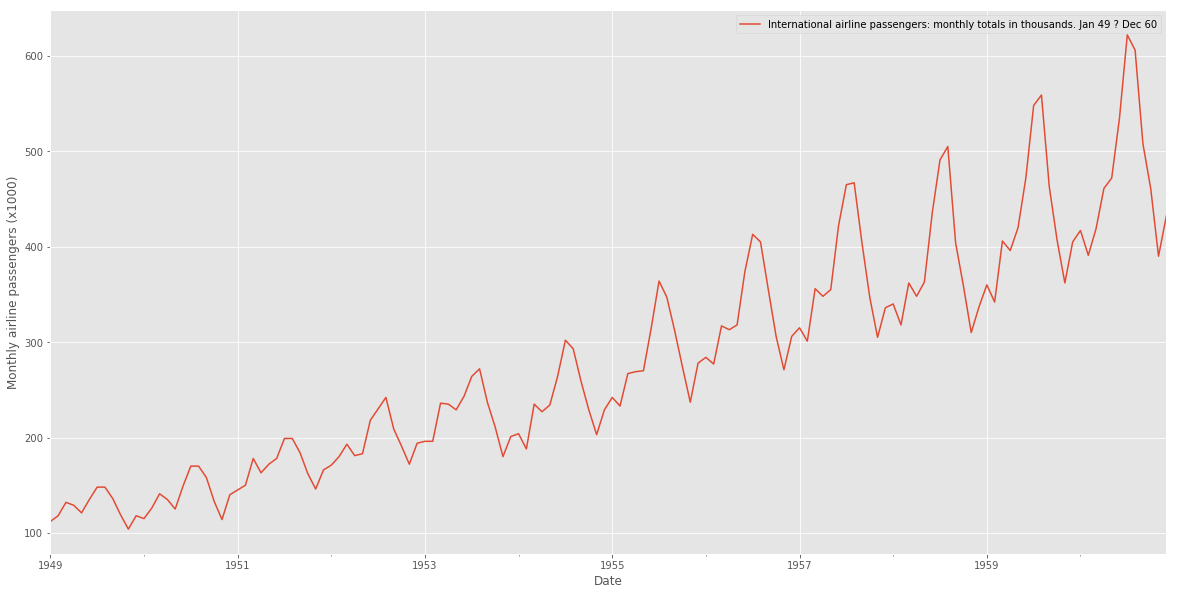

In [2]:
# Load the data
data = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and a 12 months seasonality with peaks corresponding to the northern emisphere summer period.

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: 
http://people.duke.edu/~rnau/arimrule.htm.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3). 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [21]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [22]:
train_data = data['1949-01-01':'1956-12-01']
#print(train_data)

In [23]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:1886.839202827789
SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:1498.2861801010565
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:1156.2914901508545
SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:1016.136279733757
SARIMAX(0, 0, 0)x(0, 2, 1, 12) - AIC:942.1856088448876
SARIMAX(0, 0, 0)x(0, 2, 2, 12) - AIC:834.3017303458362
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:1118.6259190717344
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:1107.256204322447
SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:1014.6452265990796
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:1109.2437994445113
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:1033.617216672956
SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:904.4213211128352
SARIMAX(0, 0, 0)x(1, 2, 0, 12) - AIC:974.439626985104
SARIMAX(0, 0, 0)x(1, 2, 1, 12) - AIC:940.2370895731925
SARIMAX(0, 0, 0)x(1, 2, 2, 12) - AIC:835.2218827762338
SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:1024.7669132306019
SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:1020.0653337818383
SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:1014.0104543340664
SAR

In [24]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 532.5132548678596 for model SARIMAX(4, 2, 1)x(4, 2, 1, 12)


In [27]:
mod1 = sm.tsa.statespace.SARIMAX(data,
                                order=(3, 1, 1),
                                seasonal_order=(3, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results1 = mod1.fit()

#print(results.summary().tables[1])

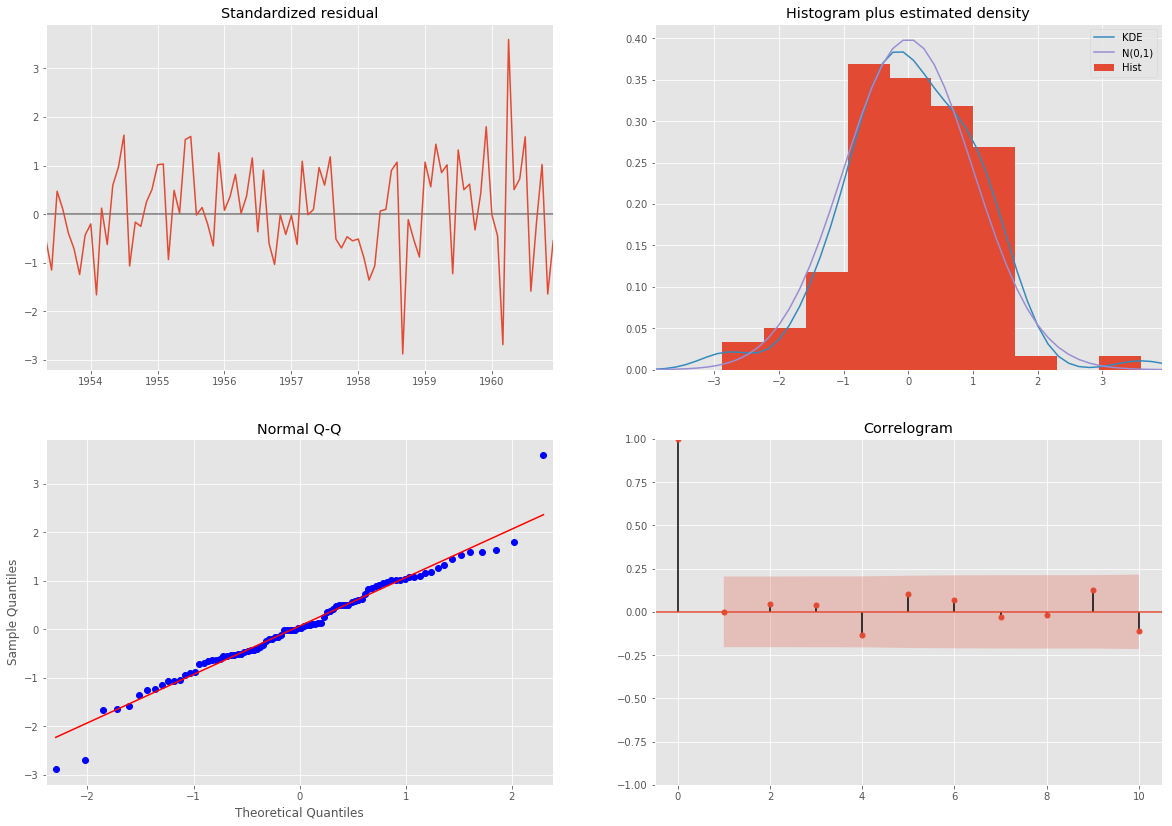

In [28]:
results1.plot_diagnostics(figsize=(20, 14))
plt.show()

C:\Users\gmonaci\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


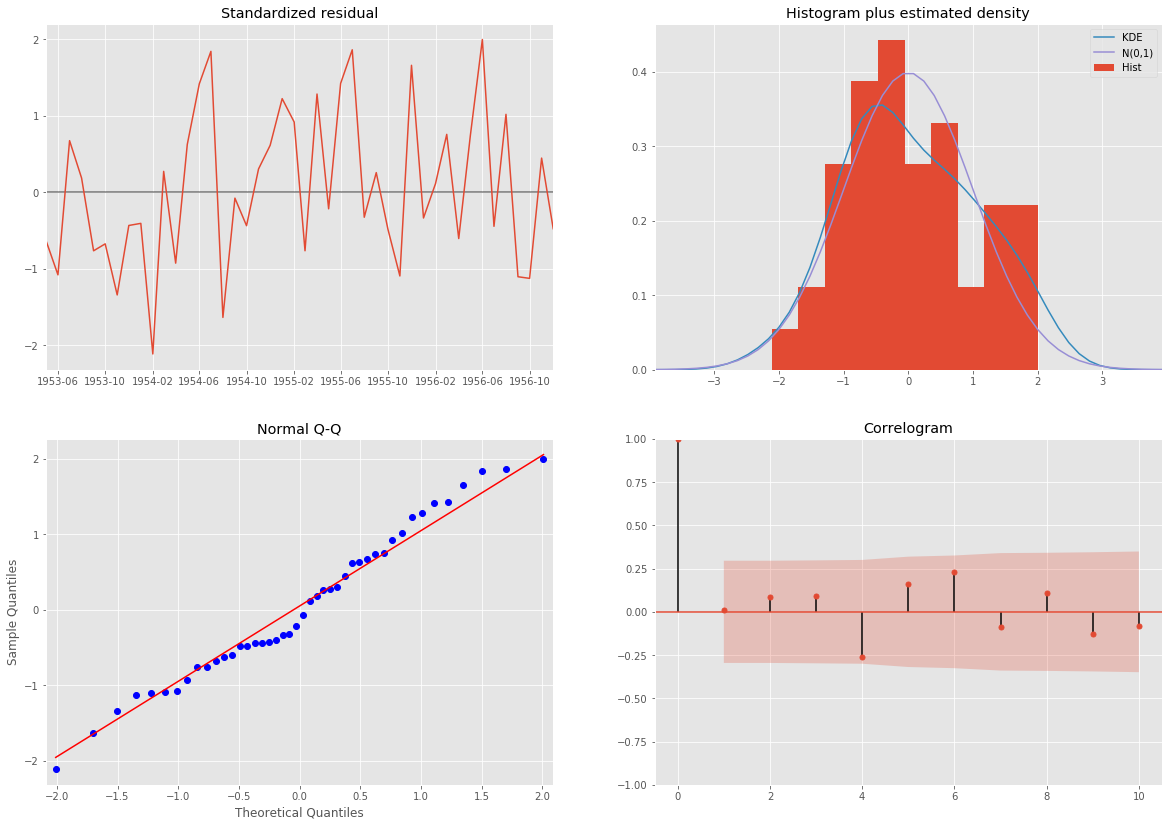

In [13]:
mod2 = sm.tsa.statespace.SARIMAX(train_data,
                                order=(3, 1, 1),
                                seasonal_order=(3, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results2 = mod2.fit()

results2.plot_diagnostics(figsize=(20, 14))
plt.show()

In [22]:
pred2 = results2.get_forecast('1965-12-01')
pred2_ci = pred2.conf_int()

pred3 = results1.get_forecast('1965-12-01')
pred3_ci = pred3.conf_int()

In [23]:
pred1 = results1.get_prediction(start='1957-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [24]:
pred0 = results1.get_prediction(start='1957-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

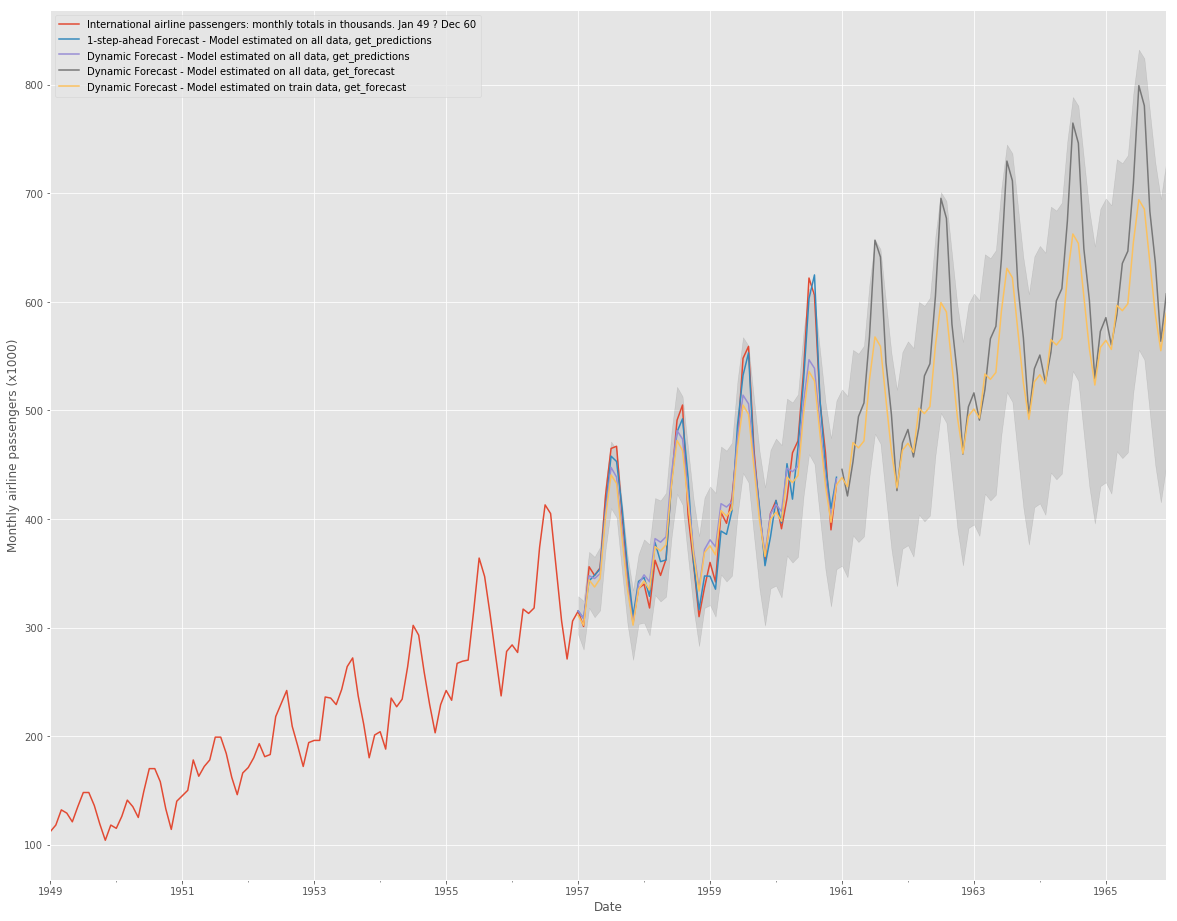

In [30]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast - Model estimated on all data, get_predictions')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast - Model estimated on all data, get_predictions')
pred3.predicted_mean.plot(ax=ax, label='Dynamic Forecast - Model estimated on all data, get_forecast')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast - Model estimated on train data, get_forecast')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()